In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score
from itertools import product
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE 

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 500)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

500

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    try:
        if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
            d['return_path_match_from'] = 1
        else:
            d['return_path_match_from'] = 0
    except:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    'subject_len': mail_dict['subject_len'],
                    'body_len': mail_dict['body_len'],
                    'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    'return_path_match_from': mail_dict['return_path_match_from'],
                    'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    'Content-type': mail_dict['Content-type'],
                    'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    'has_defects': mail_dict['has_defects'],
                    'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Newly signed Project invitation - please view proposal-.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your document is signed.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Fax Received- CSID- K7V 6B3 1910 CID- 90643249844.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Preview Secured Message!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Syncing Error - (4) Incoming failed mails..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- _INV#00044901.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Delivery complete for parcel # 30726375.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Hope all your Christmas dreams come true!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment issue 2.eml
/Users

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Rechnung IIS - 637-LMK2956  .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- thy.nguyen@pinnacol.com Be careful! malicious software ID a5iQmYe1e.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your new Chase payment notice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- PAYMENT EAA-90-22623  .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- ICBC Payment Remittance.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- File shared 11-21-2017 on behalf of Kim Willoughby.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wrong Invoice   Address.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scanned Document - (Past due Invoice-083821.Pdf & Contract_A

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Information.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- PayPal Reminder.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Tracking Number 5OX66928867835423.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE STATUS[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Explicit Content- For men over 30 ONLY!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- The amount of your's fee for confirmation.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Business Opportunity.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-46199316665-157.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- New Document.eml
/Users/

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Coloradohandandarm ( Teusday 27, 2018).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Dylan Grant.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Delivery Status Notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice PUJ #73722-AUL#YSML-2017 (21 Sep 17).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 66925_whitepaperfivemusthavesinacloudfinancialmanagementsystemus.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Question.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Important Document 2.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Email Verification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your Invoice Is Attached - 0000125794.eml
/Users/worshamn/Documents/emailProject/

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Get back the hair your missing. Even if your old or young..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The science of tomorrow here today.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Welcome to Starbucks.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Eslor kicks off October with 60% off our favorite products!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 🍻 🍴 Oracle Users in the Greater Denver area- 2 Happy Hours, Tues & Wed, Last days to RSVP.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Data Center Support Renewal - Beats Headphones.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Question on new email security threat.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Does Your Workplace Wellness Work An Interview with Laura Putnam.eml
/Users/worshamn/

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- My email was hacked yesterday.  Dont open any attachements from me.  It's fixed now..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] hola.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Jim - quick question.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don't let up to 3x more points pass you by.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- These stunning sisters have a wrinkle-reducing product.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- ONLY 1 WEEK LEFT- $500 Early-Bird Discount to Habit Design® Training Course Ends MONDAY .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Registration is Open for the 2018 National Tornado Summit.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- TreePod Fully Funded on Kickstarter!.eml
/Users/worshamn/Documents/emailP

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Look Inside for Special Offers at Schomp MINI.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Unlock your preloaded KOHL's card.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- → 7 Jobs for Underwriter - Denver.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 2018 is Around the Corner, Are You Prepared.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Big Tobaccos Settlement.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Beauty products on us..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- No more turkeys. 🦃 Get the best candidates. .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Does your phone system crash.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Thomas Koch.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- She lost a third of her body weight.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- to Jim Mcmillen.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- gfngfn.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Do you want to be smarter.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don’t waste time; make money!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Urgent- Where Do We Send AMANDA's Money.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Midwest Paint Service, Inc. - COI Request!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Health Headliners pres. Eric Neufeld on Prosthetics.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Yesssss! Amazon Giveaways & Michael Otey Live.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\H'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- TOMORROW- Why Modern Nimble ECM Systems are Replacing “Legacy Systems” (and how you can do the same).eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Megan Kelly says Fan's deserve the truth.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- We take your stem cells to 3D print functional organs copy.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Agent Interface.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- IT Professionals 2017 Salary Report.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Eliminate Print Servers before Zombies Eliminate You!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- SharePoint Support Call.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Save $1,100 thru Friday  Get In-Depth Knowledge.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\#'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Iris's Weekly Event Guide.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Great webinars- Step by step.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Ballast Water Treatment Systems Webcast- Navigating the challenges post-MEPC 71.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You have a Kohl's gift card available now..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Join the free dacadoo Holiday Season Energy Burner Challenge and compete to win a TAG Heuer Connected watch!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Så skapar du en sociala medier-strategi – anmäl dig här.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Samples of your favorite Beauty Brands free to try..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Join us at NWC&D Conference in Las Vegas!

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- OpsGenie News- April ‘18.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Give us 5 minutes and coffee's on us.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Need a contract reviewed you dont understand Use your Service!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Redis Open Source Users - Conversation Request.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Injury Management Update   Early Physical Therapy Intervention and Return to Work.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- New MBA formats designed for everyone.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Last Contact- Better Billing, Less Time.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Marketing Genius- Plastic Card Holders.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Al

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Blockchain Market 101- A $7.74B Tech & Vendor Potential.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your makeup is low quality.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- → 7 Jobs for Claims Representative - Denver.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 🚗 Pop the latest hoods at the Denver Auto Show.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You can beat alcoholism.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Alec Bradley cigar happy hour event tonight from 5-8pm with live music.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hello!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- I can't believe this happened on Shark Tank.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Secure Messaging Password Notification.eml
/U

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 34 columns):
Content-type              871 non-null object
DKIM                      884 non-null object
DMARC                     884 non-null object
DOTW                      884 non-null object
HOTD                      884 non-null object
SPF                       884 non-null object
TAP-Score                 884 non-null object
body_len                  884 non-null float64
from_tld                  884 non-null object
has_attachments           884 non-null float64
has_defects               884 non-null float64
has_email                 884 non-null float64
has_html_content          884 non-null float64
has_inline_img            884 non-null float64
has_javascript            884 non-null float64
has_masq_link             884 non-null float64
has_repeat_link           884 non-null float64
has_unsubscribe_link      884 non-null float64
has_url                   884 non-null float64
is_multipa

Create a function to clean the text

In [11]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
#         str(d).lower().translate(table).replace('\n',' ')
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
    #         stopwords_nltk = sorted(nltk.corpus.stopwords.words('english'))
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
                #if (w.lemma_ != '-PRON-' and len(w.lemma_)>term_min_len)
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text and add to the dataframe

In [12]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 11.569s


In [13]:
df['cleaned_text'] = pd.Series(corpus).values

Convert cells that are not recognized as a number or just to get rid of float

In [14]:
#https://stackoverflow.com/a/28910914
for col in [
    'body_len',
    'has_attachments',
    'has_defects',
    'has_email',
    'has_html_content',
    'has_inline_img',
    'has_javascript',
    'has_masq_link',
    'has_repeat_link',
    'has_unsubscribe_link',
    'has_url',
    'is_multipart',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_link',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'return_path_match_from',
    'subject_len',
    #'TAP-Score',
]:
    df[col] = df[col].astype(int)
    

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 35 columns):
Content-type              871 non-null object
DKIM                      884 non-null object
DMARC                     884 non-null object
DOTW                      884 non-null object
HOTD                      884 non-null object
SPF                       884 non-null object
TAP-Score                 884 non-null object
body_len                  884 non-null int64
from_tld                  884 non-null object
has_attachments           884 non-null int64
has_defects               884 non-null int64
has_email                 884 non-null int64
has_html_content          884 non-null int64
has_inline_img            884 non-null int64
has_javascript            884 non-null int64
has_masq_link             884 non-null int64
has_repeat_link           884 non-null int64
has_unsubscribe_link      884 non-null int64
has_url                   884 non-null int64
is_multipart              884 no

Break the continous data into ranges for binary conversion

In [16]:
#https://stackoverflow.com/a/40548606
df['body_len'] = pd.qcut(df['body_len'],20,duplicates='drop')
df['subject_len'] = pd.qcut(df['subject_len'],10,duplicates='drop')
df['num_attachments'] = pd.cut(df['num_attachments'],5)
df['num_email_addr'] = pd.cut(df['num_email_addr'],5)
df['num_email_link'] = pd.cut(df['num_email_link'],5)
df['num_link'] = pd.qcut(df['num_link'],10,duplicates='drop')
df['num_masq_link'] = pd.cut(df['num_masq_link'],3)
df['num_uniq_email'] = pd.qcut(df['num_uniq_email'],10,duplicates='drop')
df['num_uniq_url'] = pd.qcut(df['num_uniq_url'],10,duplicates='drop')
df['num_url'] = pd.qcut(df['num_url'],10,duplicates='drop')
df['num_url_repeats'] = pd.qcut(df['num_url_repeats'],10,duplicates='drop')

Change the continuous and categorical data into one-hot encoding (binary data)

In [17]:
categorical_cols = [
    'DKIM',
    'DMARC',
    'SPF',
    'from_tld',
    'Content-type',
    'DOTW',
    'HOTD',
    'TAP-Score',
    'body_len',
    'subject_len',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
]

In [18]:
df_categorical = pd.get_dummies(df[categorical_cols])

In [19]:
df.drop(categorical_cols, axis=1, inplace=True)

In [20]:
df = pd.concat([df,df_categorical], axis=1)

In [21]:
pd.set_option('display.max_colwidth', 40)

In [22]:
df.head()

,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,has_url,...,"num_url_(1.0, 2.0]","num_url_(2.0, 3.0]","num_url_(3.0, 5.0]","num_url_(5.0, 7.0]","num_url_(7.0, 11.0]","num_url_(11.0, 19.7]","num_url_(19.7, 341.0]","num_url_repeats_(-0.001, 1.0]","num_url_repeats_(1.0, 3.0]","num_url_repeats_(3.0, 172.0]"
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [23]:
for i in df.columns:
    print(i)

has_attachments
has_defects
has_email
has_html_content
has_inline_img
has_javascript
has_masq_link
has_repeat_link
has_unsubscribe_link
has_url
is_multipart
num_uniq_link
return_path_match_from
target
text
cleaned_text
DKIM_
DKIM_FAIL
DKIM_NONE
DKIM_PASS
DMARC_
DMARC_absent
DMARC_none
DMARC_pass
DMARC_quarantine
DMARC_reject
SPF_
SPF_ERROR
SPF_NEUTRAL
SPF_NONE
SPF_PASS
SPF_SOFTFAIL
from_tld_
from_tld_ac.uk
from_tld_bg
from_tld_bid
from_tld_biz
from_tld_ca
from_tld_ch
from_tld_co
from_tld_co.jp
from_tld_co.uk
from_tld_co.za
from_tld_com
from_tld_com.ar
from_tld_com.br
from_tld_com.do
from_tld_com.ec
from_tld_com.mx
from_tld_com.my
from_tld_com.pk
from_tld_de
from_tld_edu
from_tld_email
from_tld_es
from_tld_eu
from_tld_fi
from_tld_fr
from_tld_gob.cl
from_tld_gob.ec
from_tld_gov
from_tld_gr
from_tld_guru
from_tld_hu
from_tld_ie
from_tld_info
from_tld_io
from_tld_it
from_tld_k12.in.us
from_tld_k12.wi.us
from_tld_mx
from_tld_ne.jp
from_tld_net
from_tld_net.pl
from_tld_net.tw
from_tld_org
fr

Split the sample set into test and training sets

In [24]:
df_target = df['target']
df_feats = df.drop(['target','text'],axis=1)
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350,
    stratify=df_target
)

In [25]:
train_feats.shape

(707, 203)

In [26]:
test_feats.shape

(177, 203)

In [27]:
train_labels.value_counts()

ignore         400
investigate    307
Name: target, dtype: int64

In [28]:
test_labels.value_counts()

ignore         100
investigate     77
Name: target, dtype: int64

#### TFIDF Creation

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=False,
    binary=True,
)
train_feats_text = vectorizer.fit_transform(train_feats['cleaned_text'].values.tolist())
test_feats_text = vectorizer.transform(test_feats['cleaned_text'].values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.719s


In [30]:
train_feats_text.shape

(707, 10648)

In [31]:
test_feats_text.shape

(177, 10648)

Change TFIDF back to a dataframe so it can be combined with other features

In [32]:
#https://stackoverflow.com/a/50624143
train_feats_text_df = pd.DataFrame(train_feats_text.toarray(), columns=vectorizer.get_feature_names())

In [33]:
train_feats_text_df.head()

,aaa,ab,abbuchung,abend,ability,able,able access,able hold,able hold phone,able manufacture,...,zailab,zailab platinum,zailab platinum sponsor,zailab register,zip,zip code,zipongo,zoom,zoom discount,zoom discount base
0,0.0,0.0,0.0,0.0,0.0,0.124035,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.164399,0.0,0.164399,0.164399,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
train_feats = pd.concat([
    train_feats.reset_index(drop=True),
    train_feats_text_df.reset_index(drop=True)
],axis=1)
train_feats.drop('cleaned_text',axis=1,inplace=True)
train_feats.shape

(707, 10850)

Do the same for the test features

In [35]:
test_feats_text_df = pd.DataFrame(test_feats_text.toarray(), columns=vectorizer.get_feature_names())
test_feats_text_df = test_feats_text_df.add_prefix('LSA_')
test_feats = pd.concat([
    test_feats.reset_index(drop=True),
    test_feats_text_df.reset_index(drop=True)
],axis=1)
test_feats.drop('cleaned_text',axis=1,inplace=True)
test_feats.shape

(177, 10850)

#### SMOTE

In [36]:
print('Before SMOTE')
print(train_feats.shape)
print(train_labels.shape)
sm = SMOTE(random_state=42)
train_feats, train_labels = sm.fit_sample(train_feats, train_labels)
print('\nAfter SMOTE')
print(train_feats.shape)
print(train_labels.shape)

Before SMOTE
(707, 10850)
(707,)

After SMOTE
(800, 10850)
(800,)


Function to keep track of scoring and for printing results out

In [37]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'recall' not in score_dict:
        score_dict['recall'] = []    
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    recall = recall_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['recall'].append((clf_name,recall))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('Recall score: %0f' % recall)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [38]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.096s
LinearSVC Scores:

Accuracy of data already seen: 0.9988
Accuracy of data not seen: 0.8814
F1 score: 0.8609
Recall score: 0.844156
False Negatives: 12


In [39]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 7.867s
SVC Scores:

Accuracy of data already seen: 0.7475
Accuracy of data not seen: 0.6610
F1 score: 0.7115
Recall score: 0.961039
False Negatives: 3


#### Extra Trees Classifier

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 1.032s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8927
F1 score: 0.8790
Recall score: 0.896104
False Negatives: 8


Get Feature Importances

In [41]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = test_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_uniq_url_(-0.001, 1.0] (0.033729)
2. num_link_(-0.001, 1.0] (0.022894)
3. return_path_match_from (0.018432)
4. num_url_(-0.001, 1.0] (0.018353)
5. Content-type_Multipart/alternative (0.015801)
6. Content-type_text/plain (0.014968)
7. LSA_unsubscribe (0.014448)
8. has_unsubscribe_link (0.012562)
9. num_url_repeats_(-0.001, 1.0] (0.012325)
10. has_html_content (0.011941)
11. LSA_invoice (0.010973)
12. SPF_PASS (0.009169)
13. subject_len_(13.0, 20.0] (0.008034)
14. num_url_(11.0, 19.7] (0.006833)
15. num_uniq_url_(10.0, 16.0] (0.006381)
16. num_uniq_url_(16.0, 341.0] (0.006202)
17. num_url_repeats_(3.0, 172.0] (0.005623)
18. LSA_like (0.005622)
19. num_url_(19.7, 341.0] (0.005534)
20. DKIM_PASS (0.005483)
21. num_link_(2.0, 4.0] (0.005389)
22. from_tld_com (0.005226)
23. num_link_(9.0, 15.0] (0.005199)
24. LSA_learn (0.004891)
25. SPF_NONE (0.004871)


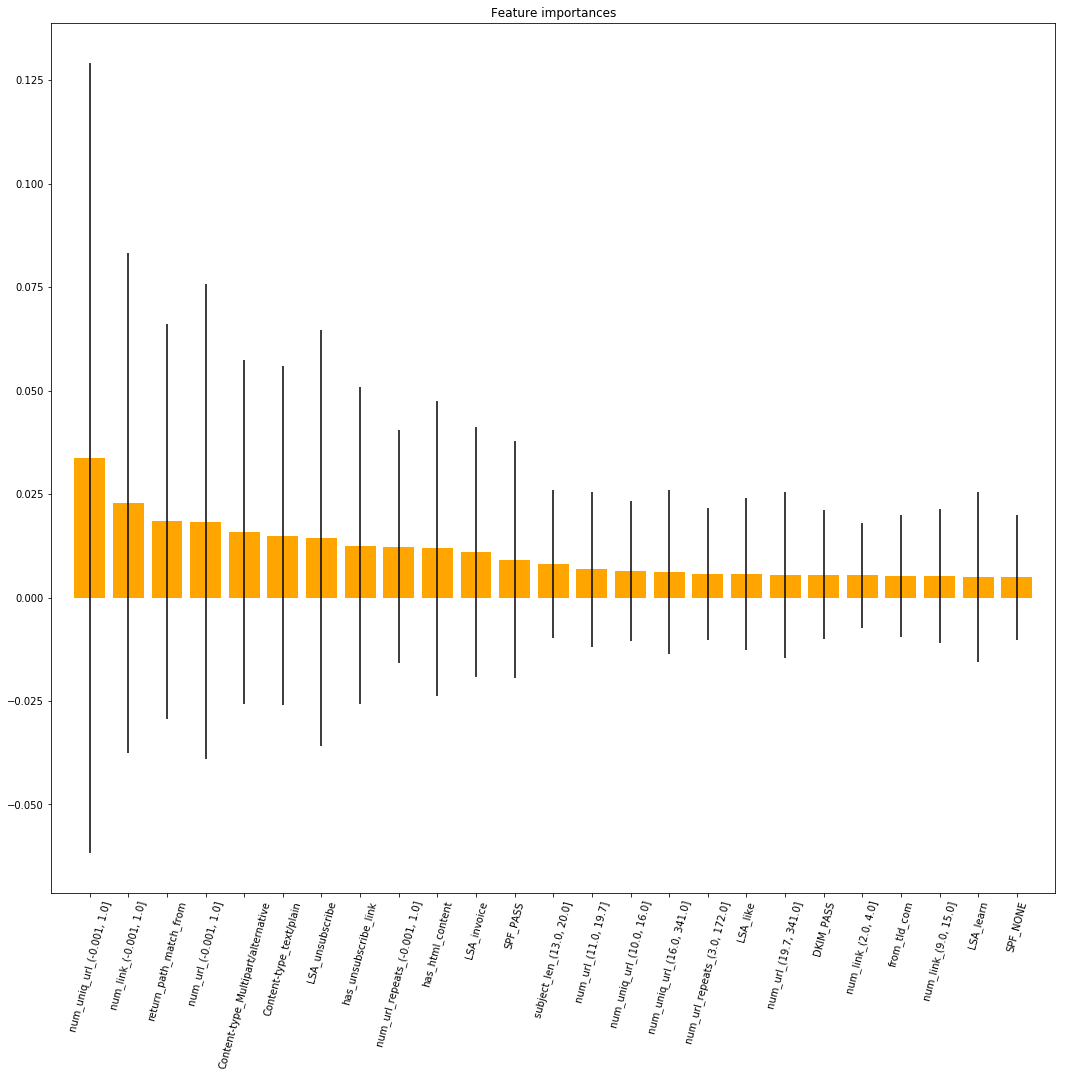

In [42]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 37.110s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 0.9988
Accuracy of data not seen: 0.8814
F1 score: 0.8662
Recall score: 0.883117
False Negatives: 9


#### XGBoost

In [44]:
# from xgboost import XGBClassifier
# t0 = time()
# xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
# xgb_clf.fit(train_feats, train_labels)
# print("done in %0.3fs" % (time() - t0))
# score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

#### Neural Net

In [45]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 18.757s
MLPClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9153
F1 score: 0.9007
Recall score: 0.883117
False Negatives: 9


#### Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
t0 = time()
nb_clf = MultinomialNB(alpha=.001)
nb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nb_clf)

done in 0.031s
MultinomialNB Scores:

Accuracy of data already seen: 0.9587
Accuracy of data not seen: 0.8983
F1 score: 0.8861
Recall score: 0.909091
False Negatives: 7


In [47]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.206s
GaussianNB Scores:

Accuracy of data already seen: 0.9975
Accuracy of data not seen: 0.8531
F1 score: 0.8143
Recall score: 0.740260
False Negatives: 20


#### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.725s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9096
F1 score: 0.8987
Recall score: 0.922078
False Negatives: 6


In [49]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = test_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_uniq_link (0.047987)
2. num_url_(-0.001, 1.0] (0.035045)
3. LSA_unsubscribe (0.024307)
4. num_link_(-0.001, 1.0] (0.023313)
5. num_uniq_url_(-0.001, 1.0] (0.022374)
6. Content-type_Multipart/alternative (0.013409)
7. return_path_match_from (0.012888)
8. has_unsubscribe_link (0.009884)
9. LSA_email (0.009700)
10. LSA_invoice (0.009528)
11. LSA_not (0.008662)
12. SPF_PASS (0.008575)
13. LSA_like (0.008435)
14. LSA_thank (0.008098)
15. LSA_time (0.006643)
16. from_tld_com (0.006501)
17. LSA_payment (0.006278)
18. LSA_th (0.006131)
19. LSA_today (0.005819)
20. num_url_repeats_(-0.001, 1.0] (0.005715)
21. LSA_document (0.005185)
22. LSA_start (0.005002)
23. LSA_view (0.004923)
24. LSA_change (0.004671)
25. has_html_content (0.004561)


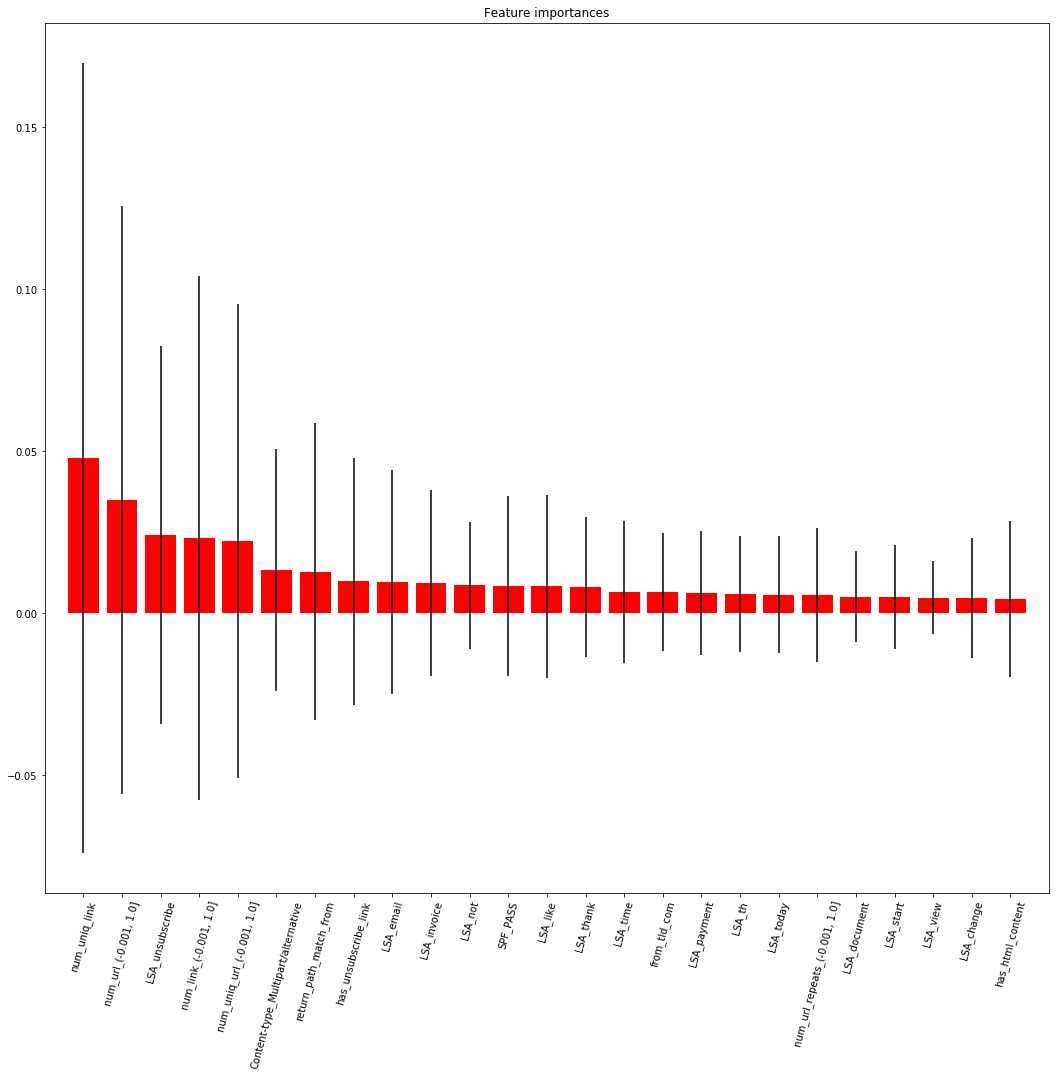

In [50]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.219s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.9300
Accuracy of data not seen: 0.8192
F1 score: 0.8025
Recall score: 0.844156
False Negatives: 12


#### NearestCentroid

In [52]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.064s
NearestCentroid Scores:

Accuracy of data already seen: 0.7475
Accuracy of data not seen: 0.6610
F1 score: 0.7115
Recall score: 0.961039
False Negatives: 3


#### AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 15.159s
AdaBoostClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8588
F1 score: 0.8408
Recall score: 0.857143
False Negatives: 11


#### QuadraticDiscriminantAnalysis

In [54]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.578s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.5763
F1 score: 0.0506
Recall score: 0.025974
False Negatives: 75


#### GaussianProcessClassifier

In [55]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats, train_labels)
#gp_pred = gp_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 13.056s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.7966
F1 score: 0.7882
Recall score: 0.870130
False Negatives: 10


#### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 1.267s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8249
F1 score: 0.8098
Recall score: 0.857143
False Negatives: 11


#### LogisticRegression

In [57]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.082s
LogisticRegression Scores:

Accuracy of data already seen: 0.9775
Accuracy of data not seen: 0.8588
F1 score: 0.8387
Recall score: 0.844156
False Negatives: 12


#### PassiveAggressiveClassifier

In [58]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done in 0.232s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.9425
Accuracy of data not seen: 0.8701
F1 score: 0.8392
Recall score: 0.779221
False Negatives: 17


#### RidgeClassifier

In [59]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.319s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9096
F1 score: 0.8987
Recall score: 0.922078
False Negatives: 6


#### SGDClassifier

In [60]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.135s
SGDClassifier Scores:

Accuracy of data already seen: 0.9062
Accuracy of data not seen: 0.8362
F1 score: 0.7883
Recall score: 0.701299
False Negatives: 23


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [61]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.405s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8870
F1 score: 0.8701
Recall score: 0.870130
False Negatives: 10


#### BaggingClassifier

In [62]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 18.676s
BaggingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8701
F1 score: 0.8553
Recall score: 0.883117
False Negatives: 9


#### VotingClassifier

In [73]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
    #('knn',knn_clf),
    ('nn',nn_clf),
#     ('et',et_clf),
    ('rf',rf_clf),
    ('rd',rd_clf),
#     ('gb',gb_clf),
#     ('cc',cc_clf),
#     ('svm',svm_clf),
    #('gp',gp_clf),
    #('lr',lr_clf),
#     ('gnb',gnb_clf),
#     ('nb',nb_clf),
],voting='hard',weights=[2,1,1])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 18.693s


In [74]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
recall = recall_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('Recall score: %0.4f' % recall)
print('False Negatives: %0d' % FN)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


VotingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9153
F1 score: 0.8993
Recall score: 0.8701
False Negatives: 10


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [65]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest Recall Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['recall'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)    
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

MLPClassifier: 0.9153
RandomForestClassifier: 0.9096
RandomForestClassifier: 0.9096


Best F1 Score:

MLPClassifier: 0.9007
RandomForestClassifier: 0.8987
RandomForestClassifier: 0.8987


Best Recall Score:

SVC: 0.9610
NearestCentroid: 0.9610
RandomForestClassifier: 0.9221


Best False Negative Classifier:

SVC: 3
NearestCentroid: 3
RandomForestClassifier: 6


#### Confusion Matrix and ROC curves of Top Algos

In [66]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [67]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [68]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

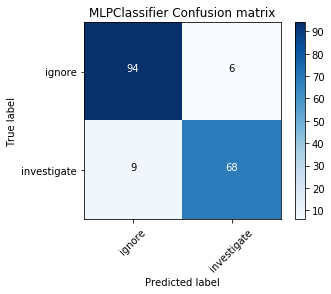

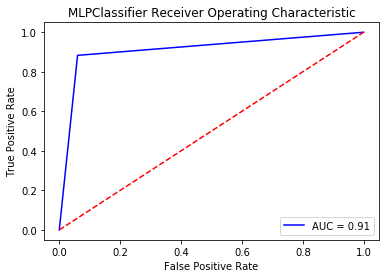

In [69]:
display_conf_mat(nn_clf,test_feats,test_labels)
plot_roc_curve(nn_clf,test_feats,test_labels)

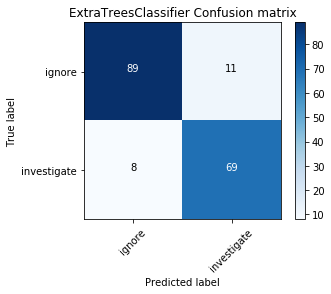

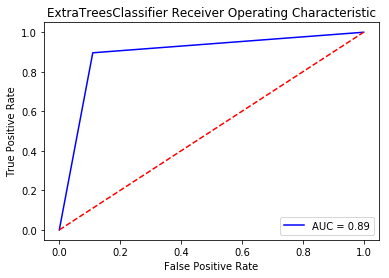

In [70]:
display_conf_mat(et_clf,test_feats,test_labels)
plot_roc_curve(et_clf,test_feats,test_labels)

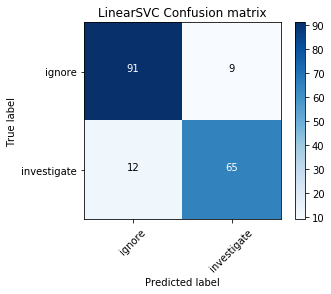

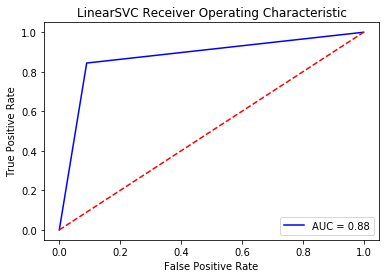

In [71]:
display_conf_mat(svm_clf,test_feats,test_labels)
plot_roc_curve(svm_clf,test_feats,test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


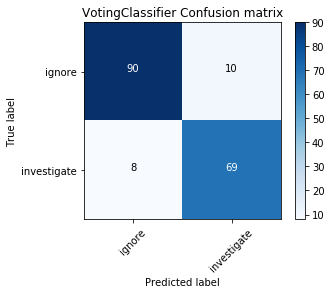

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


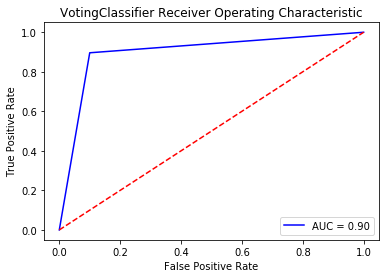

In [72]:
display_conf_mat(vt_clf,test_feats,test_labels)
plot_roc_curve(vt_clf,test_feats,test_labels)